In [2]:
import pandas as pd
import numpy as np
import pyannote.audio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
from pandas.api.types import CategoricalDtype


In [30]:
fname = '../data/raw/z-c-feisty.wav'
filename_base =os.path.splitext(os.path.basename(fname))[0]
x, sr = librosa.load(fname)
print(filename_base)
#!ffmpeg -i ../data/raw/z-c-feisty.wav ../data/processed/z-c-feisty.mp3 

z-c-feisty


In [4]:
fname_rttm = '../data/processed/test.rttm'
speaker_track = pd.read_csv(fname_rttm,header=None,delim_whitespace=True,
            names = ['x1','filename','fileid','start','duration','skip1','skip2','speaker_id','skip3'])
speaker_track['end'] = speaker_track['start']+speaker_track['duration']
bins_speaker = pd.DataFrame({'name':speaker_track['speaker_id'].values},index = pd.IntervalIndex.from_arrays(left = speaker_track['start'],right=speaker_track['end']))
speaker_track.drop(['skip1','skip2','skip3'],axis=1,inplace = True)
speaker_track.head(2)
cat_type = CategoricalDtype(categories=speaker_track['speaker_id'].unique().tolist())


In [5]:
#librosa.output.write_wav('../data/raw/z-c-feisty.mp3', x, sr)
df = pd.DataFrame({"time":np.arange(x.shape[0])/sr,"amplitude":x})


In [6]:
def find_speaker(x):
    try:
        res =bins_speaker.loc[x,'name'].values[0]
    except:
        res=np.nan
    return res
#t = tmp.reset_index()
tmp = df.sample(frac=0.005).sort_values('time')
speaker_id = tmp['time'].apply(lambda x: find_speaker(x))
speaker_id.head()
tmp['speaker']  =speaker_id.astype(cat_type)
tmp.set_index('time',inplace=True,drop=False)


 49%|████▉     | 165/338 [01:02<01:03,  2.73it/s]


 97%|█████████▋| 328/338 [02:01<00:03,  2.86it/s]


100%|██████████| 338/338 [02:05<00:00,  2.61it/s]

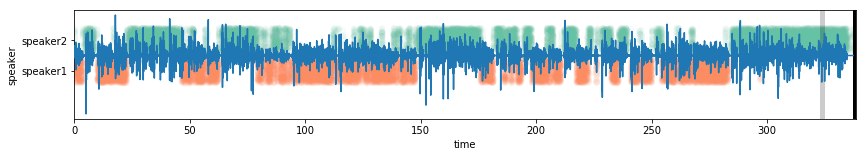

In [68]:
import seaborn as sns
from tqdm import trange
folder_output =os.path.abspath(os.path.splitext(fname)[0])
folder_output_ff =os.path.abspath(os.path.splitext(fname)[0])

os.makedirs(folder_output,exist_ok=True)
#fig,ax = plt.subplots(figsize=(27, 5),nrows=2,gridspec_kw = {'height_ratios':[3,2]})
fig,ax = plt.subplots(figsize=(14, 2),nrows=1)

tmp['speaker_cat'] = tmp['speaker'].cat.codes
tmp.loc[tmp['speaker_cat'] == -1,'speaker_cat'] = np.NaN
sns.stripplot(x='time',y='speaker',data= tmp,ax=ax,alpha=0.05,palette='Set2',jitter = 0.4,size=6.5,zorder=0)
tmp['amp_scaled'] = np.mean(ax.get_ylim())+tmp['amplitude']*len(tmp['speaker'].unique())

tmp['amp_scaled'].plot(ax=ax,zorder=10)
sec=0
dsec= 15
#line = ax[1].axvline(sec,c = 'k',linewidth=5)
line = ax.axvline(sec,c = 'k',linewidth=5)
line_l = ax.axvline(sec-dsec*0.95,c = 'k',alpha=0.2,linewidth=5)
line_r = ax.axvline(sec+dsec*0.95,c = 'k',alpha=0.2,linewidth=5)

n_frames = 337


sec_per_frame = (df['time'].max()+1) / n_frames
ax.set_xlim([0,df['time'].max()+1])

frame_rate = x.shape[0]/sr/(n_frames+1)
tmp_file_ffmpeg = ['ffconcat version 1.0\n']




for fr in trange(n_frames+1):
    sec = np.round(fr * sec_per_frame)
#    sub_tmp = tmp[(tmp.index>sec-dsec) & (tmp.index<sec+dsec)].copy()
#    sns.stripplot(x='time',y='speaker',data= sub_tmp,ax=ax[0],alpha=0.5,palette='Set2',jitter = 0.3,size=7.5,zorder=0)
 #   sub_tmp['amp_scaled'] = sub_tmp['speaker_cat']+sub_tmp['amplitude'] * sub_tmp['speaker_cat'].unique().shape[0]
 #   sub_tmp['amp_scaled'].plot(ax=ax[0],zorder=10)
    
  #  line_top_panel = ax[0].axvline(sec,c = 'k',linewidth=5)
    png_name = f'{np.int(fr):04d}.png'
    fig_name = os.path.join(folder_output,png_name)
    line.set_xdata([sec,sec])
    line_l.set_xdata(sec-dsec*0.95)
    line_r.set_xdata(sec+dsec*0.95)
 #   ax[0].set_xlabel('')
    fig.savefig(fig_name,dpi = 150)
    tmp_file_ffmpeg.append(f'file {png_name}\n')
    tmp_file_ffmpeg.append(f'duration {frame_rate}\n')
  #  ax[0].clear()

In [69]:
tmp_file_ffmpeg_fixed = tmp_file_ffmpeg
tmp_file_ffmpeg_fixed.append(f'file {png_name}\n')
ffstr = ''.join(tmp_file_ffmpeg_fixed)
with open(os.path.join(folder_output,f'{filename_base}.txt'),'w') as f:
    f.write(ffstr)

In [67]:
len(tmp_file_ffmpeg)
tmp_file_ffmpeg[-1]

'file 0337.png\n'

In [42]:
#ffmpeg -f concat -i input.txt -vsync vfr -pix_fmt yuv420p output.mp4
concat_file = os.path.join(folder_output,f'{filename_base}.txt')
cmd = f'ffmpeg -pix_fmt yuv420p -vsync vfr -i {concat_file} output.mp4'
print(cmd)

ffmpeg -pix_fmt yuv420p -vsync vfr -i D:\Repos\diurisation-pet-proj\data\raw\z-c-feisty\z-c-feisty.txt output.mp4


In [46]:
''.join(tmp_file_ffmpeg_fixed)

'ffconcat version 1.0\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0000.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0001.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0002.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0003.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0004.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0005.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0006.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0007.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0008.png\nduration 0.9980651826805673\nfile D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty\\0009.png\ndurati

In [37]:
os.path.abspath(fname)

'D:\\Repos\\diurisation-pet-proj\\data\\raw\\z-c-feisty.wav'

In [70]:
2818555/1e3/3600


0.7829319444444444